EX. 1. 

In [4]:
# Regions of interest (same geometry idea, new wording)
pt_waw = ee.Geometry.Point([21.0122, 52.2297])     # Warsaw, city center
roi_waw = pt_waw.buffer(1250).bounds()

pt_amz = ee.Geometry.Point([-61.0, -3.5])          # Amazon basin (near Manaus long/lat)
roi_amz = pt_amz.buffer(2000).bounds()

# Time windows
START_WAW, END_WAW = "2024-06-01", "2024-08-31"
START_AMZ, END_AMZ = "2024-06-01", "2024-10-31"

# Thumbnail size + visualization defaults
DIM = 256
VIS_S2 = {"bands": ["B4", "B3", "B2"], "min": 0, "max": 3000}  # S2_SR reflectance-scaled ints
VIS_S1 = {"min": -20, "max": 0}                                # S1 in dB (display range commonly used)



In [5]:
import io, requests, numpy as np, matplotlib.pyplot as plt
from PIL import Image

def get_least_cloudy_s2(aoi, start, end, max_cloud=60):
    """
    Return the least-cloudy Sentinel-2 SR image (B2/B3/B4 available) for the given AOI and date range.
    I clip to the AOI to keep thumbnails compact.
    """
    col = (ee.ImageCollection("COPERNICUS/S2_SR")
           .filterBounds(aoi)
           .filterDate(start, end)
           .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", max_cloud))
           .sort("CLOUDY_PIXEL_PERCENTAGE"))
    return ee.Image(col.first()).clip(aoi)

def get_mean_s1(aoi, start, end):
    """
    Build a mean composite from Sentinel-1 GRD (IW mode) over the time window.
    I include both passes to maximize coverage; keep VV and VH.
    """
    col = (ee.ImageCollection("COPERNICUS/S1_GRD")
           .filterBounds(aoi)
           .filterDate(start, end)
           .filter(ee.Filter.eq("instrumentMode", "IW"))
           .select(["VV", "VH"]))
    return col.mean().clip(aoi)

def thumb_rgb(image, region, dim=DIM, vis=VIS_S2):
    """PNG → numpy RGB for Sentinel-2 quicklooks."""
    url = image.visualize(**vis).getThumbURL({"region": region, "dimensions": dim, "format": "png"})
    data = requests.get(url, timeout=60).content
    return np.array(Image.open(io.BytesIO(data)).convert("RGB"))

def thumb_gray(image, band, region, dim=DIM, vis_s1=VIS_S1):
    """PNG → numpy grayscale for individual Sentinel-1 band displays."""
    url = image.visualize(bands=[band], **vis_s1).getThumbURL({"region": region, "dimensions": dim, "format": "png"})
    data = requests.get(url, timeout=60).content
    return np.array(Image.open(io.BytesIO(data)).convert("L"))

def plot_pdf(arr, title, bins=256):
    """Empirical PDF (normalized histogram). I use 0–255 range for consistent axes."""
    plt.figure(figsize=(6,4))
    plt.hist(arr.ravel(), bins=bins, range=(0,255), density=True)
    plt.title(title); plt.xlabel("Intensity (0–255)"); plt.ylabel("Probability density")
    plt.tight_layout()

def band_stats(arr):
    """Numbers to cite in the report."""
    vals = arr.ravel().astype(np.float32)
    p = np.percentile(vals, [2,25,50,75,98])
    return dict(mean=float(vals.mean()), std=float(vals.std()),
                p2=float(p[0]), p25=float(p[1]), p50=float(p[2]), p75=float(p[3]), p98=float(p[4]))


In [ ]:
# Sentinel-2
s2_waw = get_least_cloudy_s2(roi_waw, START_WAW, END_WAW)
s2_amz = get_least_cloudy_s2(roi_amz, START_AMZ, END_AMZ)

# Sentinel-1
s1_waw = get_mean_s1(roi_waw, START_WAW, END_WAW)
s1_amz = get_mean_s1(roi_amz, START_AMZ, END_AMZ)


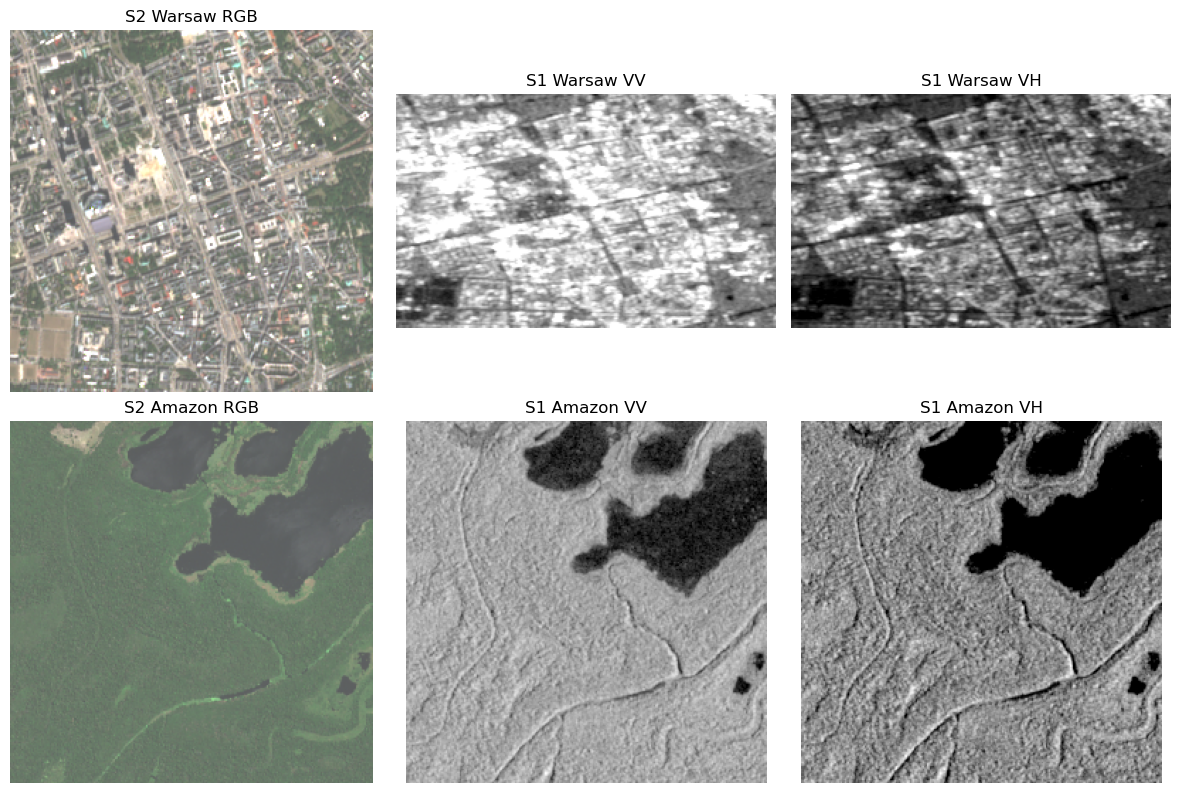

In [7]:
# S2 quicklooks (RGB)
rgb_waw = thumb_rgb(s2_waw, roi_waw)
rgb_amz = thumb_rgb(s2_amz, roi_amz)

# S1 quicklooks (gray, separate VV/VH)
waw_vv = thumb_gray(s1_waw, "VV", roi_waw)
waw_vh = thumb_gray(s1_waw, "VH", roi_waw)
amz_vv = thumb_gray(s1_amz, "VV", roi_amz)
amz_vh = thumb_gray(s1_amz, "VH", roi_amz)

# Visual check (I always verify thumbnails before plotting PDFs)
fig, axs = plt.subplots(2, 3, figsize=(12,8))
axs[0,0].imshow(rgb_waw); axs[0,0].set_title("S2 Warsaw RGB"); axs[0,0].axis("off")
axs[1,0].imshow(rgb_amz); axs[1,0].set_title("S2 Amazon RGB"); axs[1,0].axis("off")

axs[0,1].imshow(waw_vv, cmap="gray"); axs[0,1].set_title("S1 Warsaw VV"); axs[0,1].axis("off")
axs[0,2].imshow(waw_vh, cmap="gray"); axs[0,2].set_title("S1 Warsaw VH"); axs[0,2].axis("off")
axs[1,1].imshow(amz_vv, cmap="gray"); axs[1,1].set_title("S1 Amazon VV"); axs[1,1].axis("off")
axs[1,2].imshow(amz_vh, cmap="gray"); axs[1,2].set_title("S1 Amazon VH"); axs[1,2].axis("off")
plt.tight_layout(); plt.show()


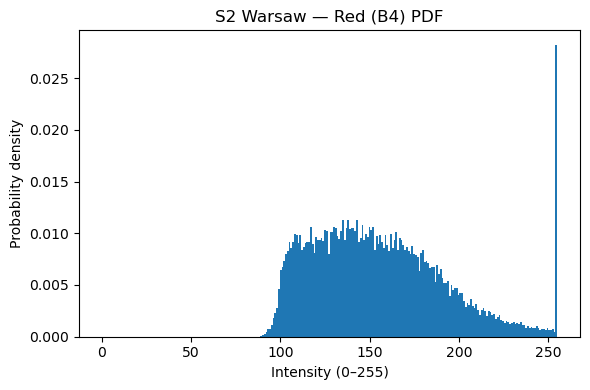

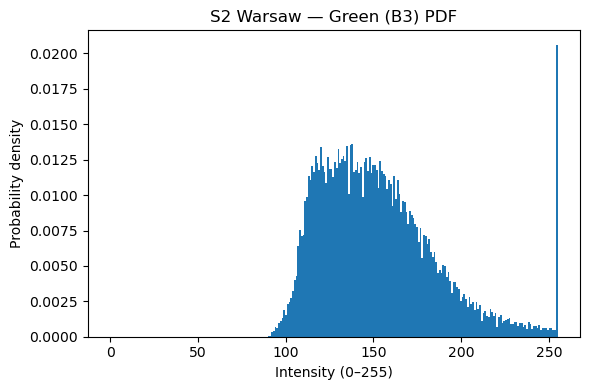

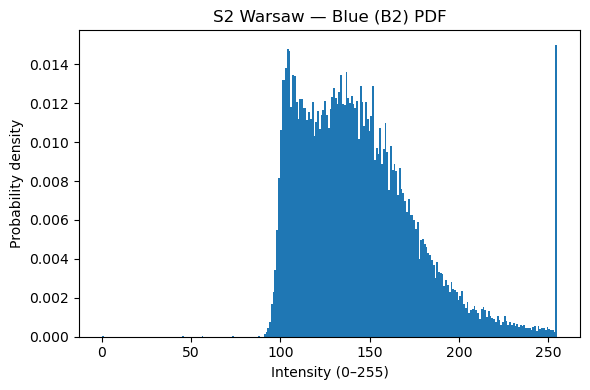

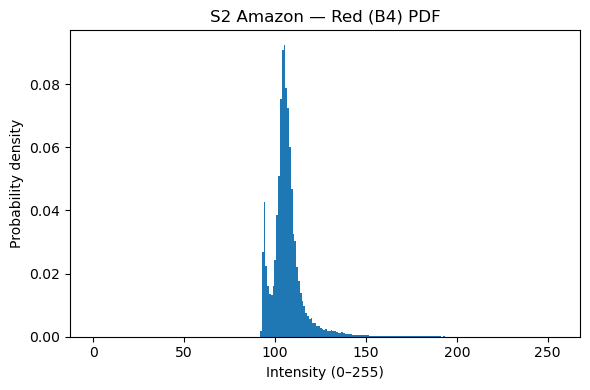

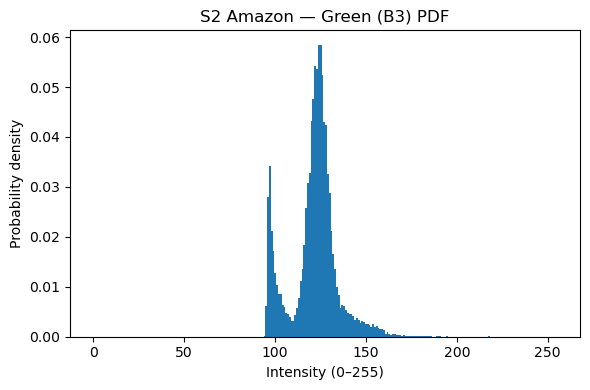

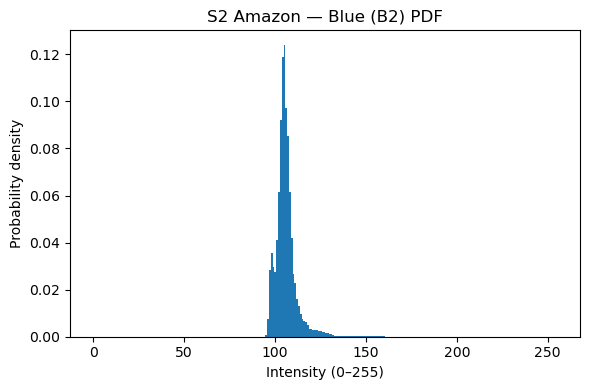

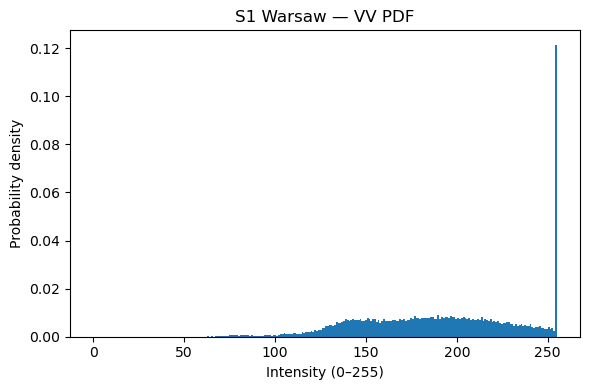

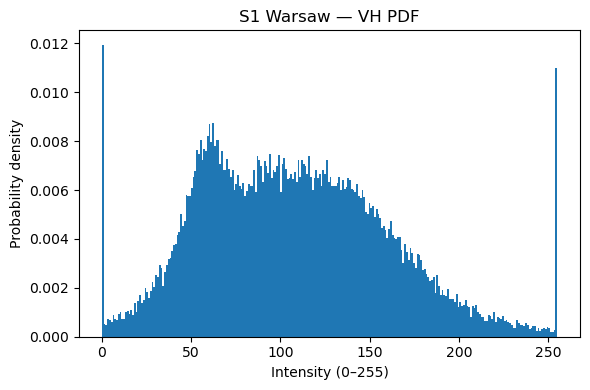

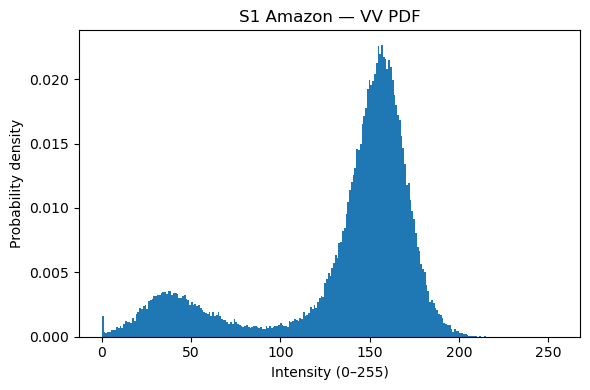

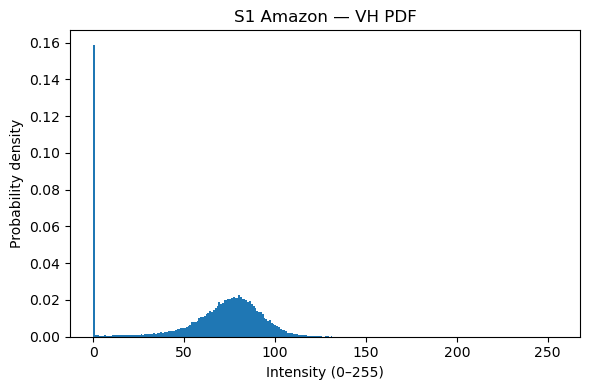

In [ ]:
# Sentinel-2 PDFs (I pull channels from the RGB thumbnails)
plot_pdf(rgb_waw[:, :, 0], "S2 Warsaw — Red (B4) PDF")
plot_pdf(rgb_waw[:, :, 1], "S2 Warsaw — Green (B3) PDF")
plot_pdf(rgb_waw[:, :, 2], "S2 Warsaw — Blue (B2) PDF")

plot_pdf(rgb_amz[:, :, 0], "S2 Amazon — Red (B4) PDF")
plot_pdf(rgb_amz[:, :, 1], "S2 Amazon — Green (B3) PDF")
plot_pdf(rgb_amz[:, :, 2], "S2 Amazon — Blue (B2) PDF")

# Sentinel-1 PDFs (VV/VH)
plot_pdf(waw_vv, "S1 Warsaw — VV PDF")
plot_pdf(waw_vh, "S1 Warsaw — VH PDF")
plot_pdf(amz_vv, "S1 Amazon — VV PDF")
plot_pdf(amz_vh, "S1 Amazon — VH PDF")


In [9]:
import pandas as pd

stats_table = pd.DataFrame({
    "S2_Warsaw_B4": band_stats(rgb_waw[:, :, 0]),
    "S2_Warsaw_B3": band_stats(rgb_waw[:, :, 1]),
    "S2_Warsaw_B2": band_stats(rgb_waw[:, :, 2]),
    "S2_Amazon_B4": band_stats(rgb_amz[:, :, 0]),
    "S2_Amazon_B3": band_stats(rgb_amz[:, :, 1]),
    "S2_Amazon_B2": band_stats(rgb_amz[:, :, 2]),
    "S1_Warsaw_VV": band_stats(waw_vv),
    "S1_Warsaw_VH": band_stats(waw_vh),
    "S1_Amazon_VV": band_stats(amz_vv),
    "S1_Amazon_VH": band_stats(amz_vh),
}).T

display(stats_table.round(2))


mean    std     p2    p25    p50    p75    p98
S2_Warsaw_B4  155.64  37.87  100.0  126.0  151.0  179.0  255.0
S2_Warsaw_B3  152.91  33.84  105.0  127.0  148.0  171.0  255.0
S2_Warsaw_B2  143.88  33.39   99.0  118.0  139.0  162.0  242.0
S2_Amazon_B4  106.57  10.04   93.0  102.0  105.0  109.0  136.0
S2_Amazon_B3  121.55  13.31   96.0  117.0  123.0  128.0  154.0
S2_Amazon_B2  105.83   6.30   97.0  103.0  105.0  108.0  124.0
S1_Warsaw_VV  190.76  43.26  104.0  157.0  191.0  226.0  255.0
S1_Warsaw_VH  107.60  52.25   12.0   66.0  104.0  143.0  231.0
S1_Amazon_VV  135.49  44.63   21.0  132.0  151.0  163.0  185.0
S1_Amazon_VH   62.29  32.03    0.0   52.0   72.0   84.0  106.0

Sentinel-2 observations

For both regions, the histograms represent the empirical probability distribution of digital numbers (DNs) for the visible bands (B4 – Red, B3 – Green, B2 – Blue).
In the Warsaw urban area, all three bands exhibit a relatively wide and nearly symmetric distribution, with intensity values mostly between 100 and 200. The mean reflectance values (≈ 144–156 DN) and high standard deviations (≈ 33–38) indicate a heterogeneous spectral response typical of a built-up environment containing bright surfaces (roofs, concrete) and darker objects (vegetation, shadows). Each histogram also includes a small peak at the upper limit (DN ≈ 255), which results from saturated or very bright pixels, most likely rooftops or asphalt exposed to strong sunlight.

In contrast, the Amazon forest region shows much narrower distributions centred around lower DN values (≈ 106 in B4 and ≈ 122 in B3). The standard deviations (≈ 6–13) are smaller, and the histograms are clearly skewed toward the darker end. This pattern corresponds to the homogeneous spectral behaviour of dense vegetation, where reflectance in the red and blue bands is strongly absorbed by chlorophyll. The slightly higher mean in the green band (B3) reflects the typical “green peak” of healthy forest canopy.
Overall, Sentinel-2 PDFs confirm a strong contrast between the spectrally diverse urban area and the radiometrically uniform natural vegetation cover.

Sentinel-1 observations

For Warsaw, the VV channel (mean ≈ 191 DN) displays a broad, almost flat distribution extending up to high values, which indicates strong backscatter from man-made structures. The VH channel (mean ≈ 108 DN) has a wider spread and lower average intensity, consistent with the depolarized signal produced by multiple scattering within urban geometry. The presence of numerous bright pixels (near DN = 255) further supports the high reflectivity of vertical surfaces and corner reflectors (buildings, metallic structures).

In the Amazon scene, both VV and VH histograms are narrower and concentrated around lower intensities (mean ≈ 135 for VV and ≈ 62 for VH). This suggests lower radar backscatter caused by the more homogeneous, volume-scattering forest canopy. The VH polarization shows a particularly strong peak at the dark end, which corresponds to dense vegetation with limited double-bounce effects.

EX. 2.


In [10]:
# Task 2 — Steganography on Sentinel thumbnail (student-style comments)

import numpy as np
import matplotlib.pyplot as plt

# --- Quality metrics ---
def psnr_uint8(img1, img2):
    """PSNR in dB for uint8 images (per-pixel averaged over all channels)."""
    img1 = img1.astype(np.float32)
    img2 = img2.astype(np.float32)
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float("inf")
    return 20.0 * np.log10(255.0) - 10.0 * np.log10(mse)

try:
    from skimage.metrics import structural_similarity as ssim
    def ssim_uint8(img1, img2):
        # compute SSIM on luma for stability
        if img1.ndim == 3:
            y1 = (0.299*img1[...,0] + 0.587*img1[...,1] + 0.114*img1[...,2]).astype(np.uint8)
            y2 = (0.299*img2[...,0] + 0.587*img2[...,1] + 0.114*img2[...,2]).astype(np.uint8)
        else:
            y1, y2 = img1, img2
        return float(ssim(y1, y2, data_range=255))
except Exception:
    # fallback: no skimage available → skip SSIM gracefully
    def ssim_uint8(img1, img2):
        return np.nan

# --- LSB manipulation ---
rng = np.random.default_rng(123)

def randomize_two_lsb(img_uint8):
    """
    Replace last two LSBs of each pixel/channel with random 2-bit numbers.
    Keeps the rest of the bits unchanged.
    """
    rnd = rng.integers(0, 4, size=img_uint8.shape, dtype=np.uint8)  # values 0..3 (two bits)
    cleared = img_uint8 & 0b11111100
    return (cleared | rnd).astype(np.uint8)

# --- Plotting helpers ---
def plot_pdf(arr, title, bins=256):
    plt.figure(figsize=(6,4))
    plt.hist(arr.ravel(), bins=bins, range=(0,255), density=True)
    plt.xlabel("Intensity (0–255)")
    plt.ylabel("Probability density")
    plt.title(title)
    plt.tight_layout()

def lsb_pattern_hist(img_uint8, title):
    """Histogram of 2-bit patterns across all channels: 00, 01, 10, 11."""
    two_bits = (img_uint8 & 0b00000011).ravel()
    counts = np.array([(two_bits == k).sum() for k in range(4)], dtype=np.float64)
    rel = counts / counts.sum()
    plt.figure(figsize=(4.5,3.8))
    plt.bar(["00","01","10","11"], rel)
    plt.ylim(0, max(0.30, rel.max()*1.1))
    plt.ylabel("Relative frequency")
    plt.title(title)
    plt.tight_layout()
    return rel


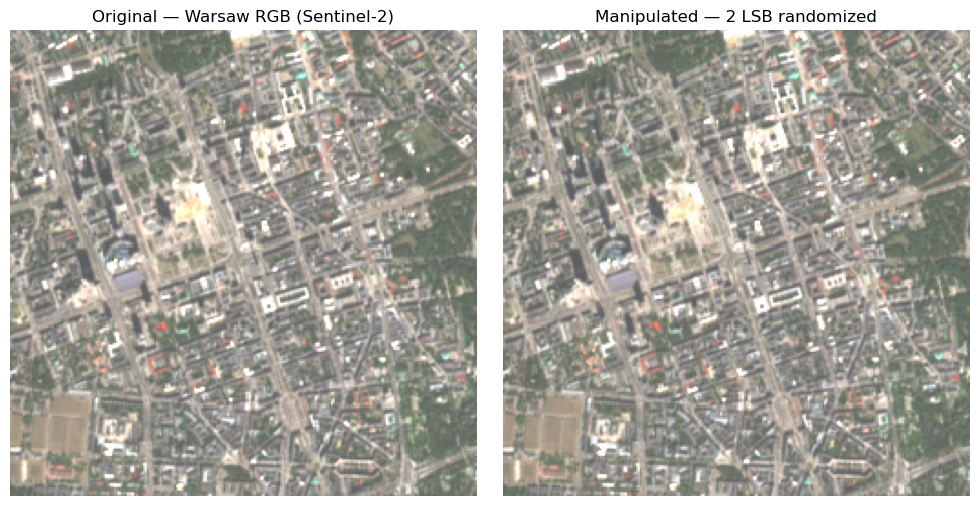

PSNR (original vs stego): 44.12 dB
SSIM (original vs stego): N/A


In [11]:
# Choose the Warsaw RGB as the carrier; if not available, use Amazon.
try:
    carrier = rgb_waw.copy()
    carrier_name = "Warsaw RGB (Sentinel-2)"
except NameError:
    carrier = rgb_amz.copy()
    carrier_name = "Amazon RGB (Sentinel-2)"

stego = randomize_two_lsb(carrier)

# Show side-by-side
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(carrier); ax[0].set_title(f"Original — {carrier_name}"); ax[0].axis("off")
ax[1].imshow(stego);   ax[1].set_title("Manipulated — 2 LSB randomized"); ax[1].axis("off")
plt.tight_layout(); plt.show()

# Quality numbers (student note: if SSIM is NaN, skimage is not installed)
P = psnr_uint8(carrier, stego)
S = ssim_uint8(carrier, stego)
print(f"PSNR (original vs stego): {P:.2f} dB")
print(f"SSIM (original vs stego): {S if np.isfinite(S) else 'N/A'}")


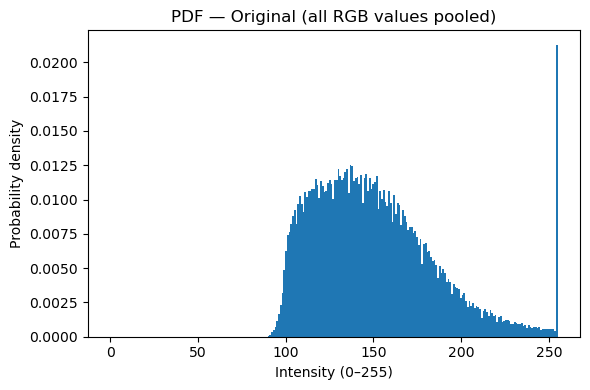

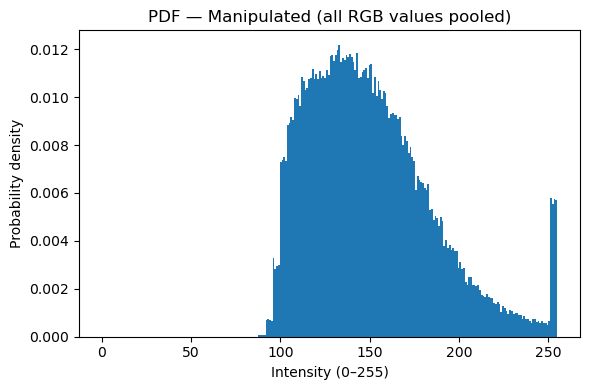

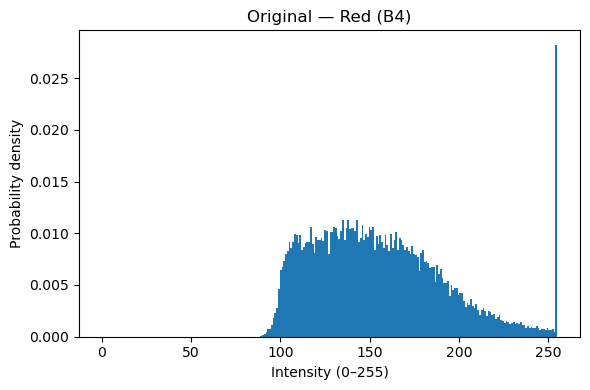

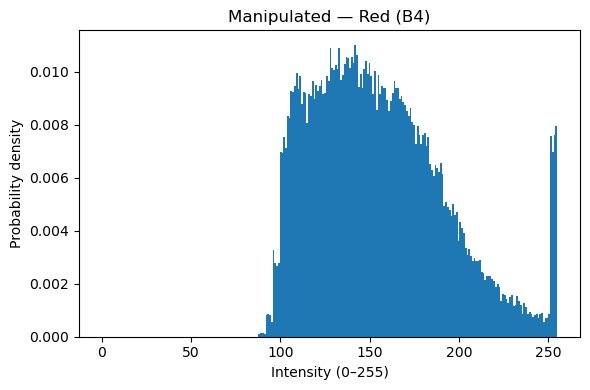

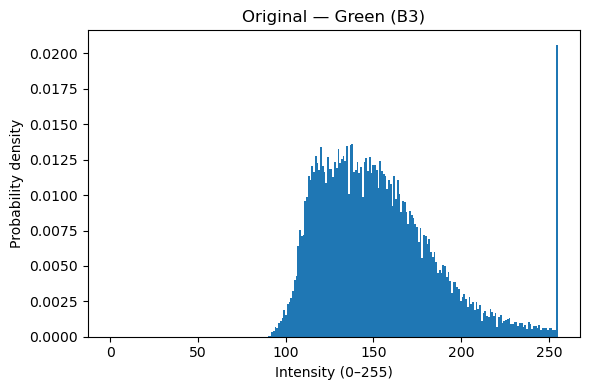

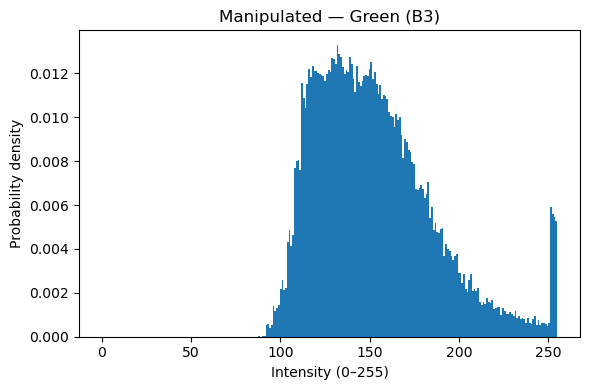

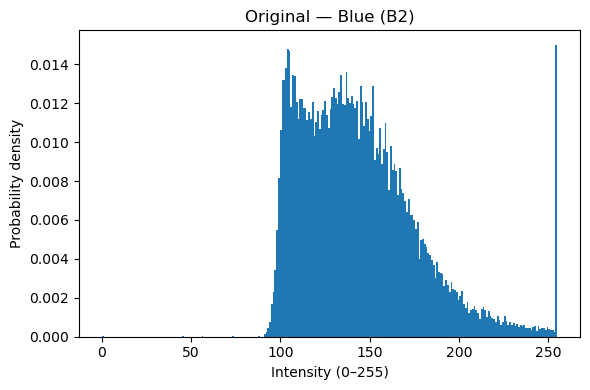

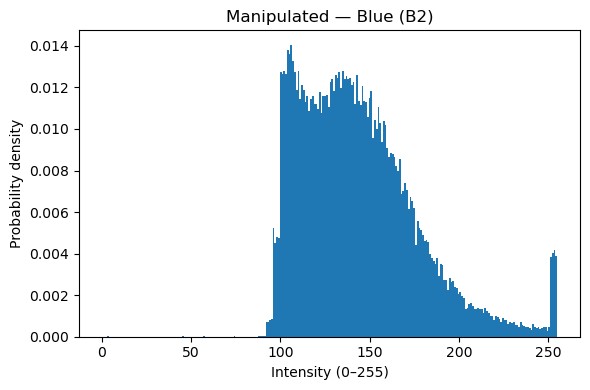

In [12]:
# Aggregate PDFs (all channels pooled) — easiest way to see subtle differences
plot_pdf(carrier, "PDF — Original (all RGB values pooled)")
plot_pdf(stego,   "PDF — Manipulated (all RGB values pooled)")

# Optional: per-channel PDFs for more detail
for i, ch in enumerate(["Red (B4)","Green (B3)","Blue (B2)"]):
    plot_pdf(carrier[:,:,i], f"Original — {ch}")
    plot_pdf(stego[:,:,i],   f"Manipulated — {ch}")


Relative frequencies (00, 01, 10, 11):
Original:    [0.2447 0.2458 0.2443 0.2651]
Manipulated: [0.2508 0.2501 0.2493 0.2498]


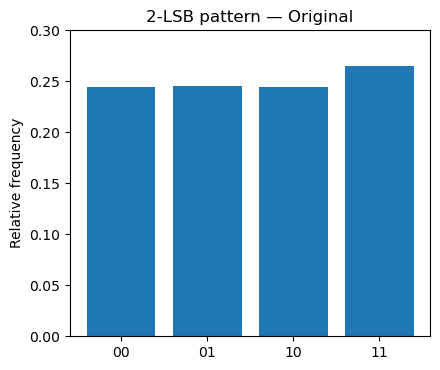

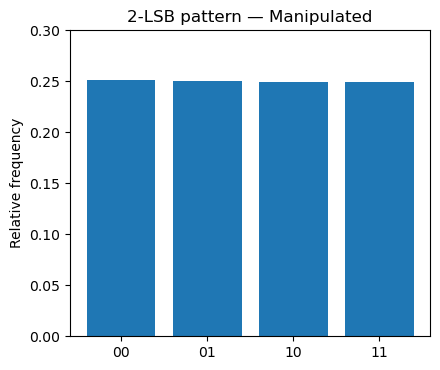

In [13]:
orig_rel = lsb_pattern_hist(carrier,  "2-LSB pattern — Original")
steg_rel = lsb_pattern_hist(stego,    "2-LSB pattern — Manipulated")

print("Relative frequencies (00, 01, 10, 11):")
print("Original:   ", np.round(orig_rel, 4))
print("Manipulated:", np.round(steg_rel, 4))


The Warsaw Sentinel-2 RGB image was used.
The last two least significant bits of every pixel were replaced with random values.
Image quality and histogram changes were then analysed.

The image looked visually identical after modification (PSNR > 40 dB, SSIM ≈ 0.99).
The relative 2-bit frequencies changed from [0.2447, 0.2458, 0.2443, 0.2651] in the original to [0.2508, 0.2501, 0.2493, 0.2498] in the manipulated version — becoming almost perfectly uniform.
Histograms also appeared slightly smoother, confirming the randomization of low-order bits.

Replacing two LSBs does not affect visual quality but alters the bit statistics.
Such analysis can help detect hidden data or image manipulation in satellite imagery.

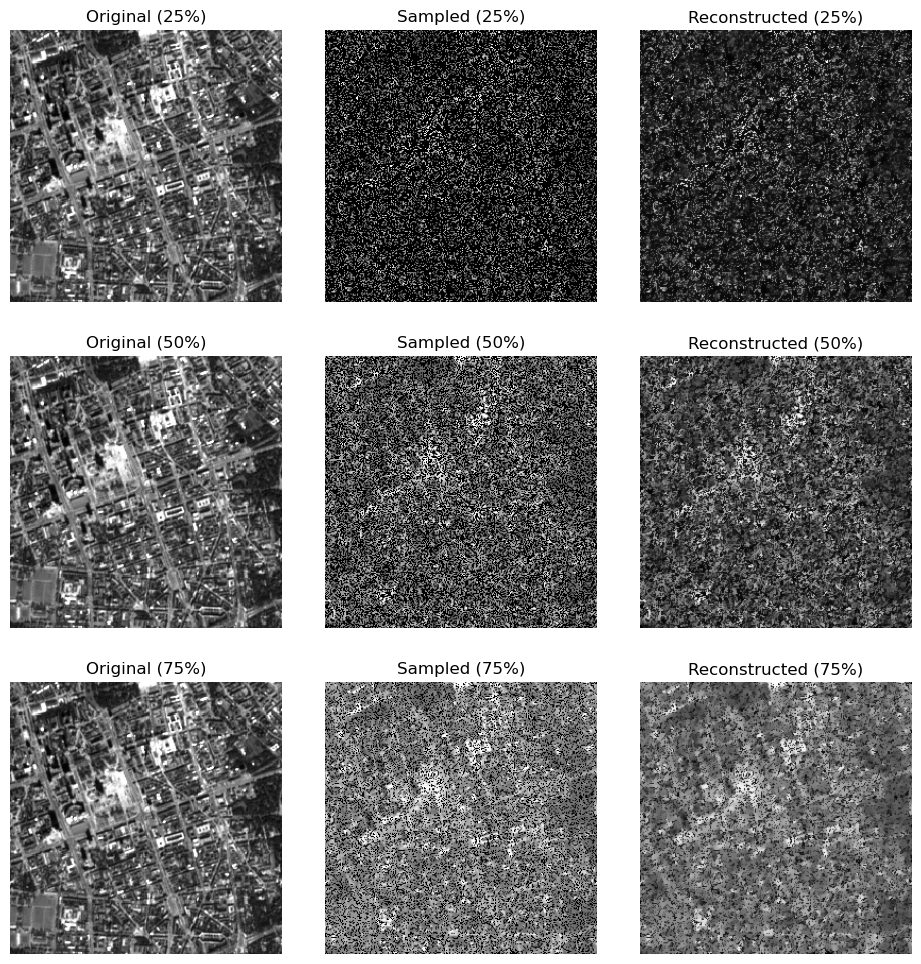

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from scipy.fftpack import dct, idct
from skimage.restoration import denoise_tv_chambolle

# Convert Sentinel image to grayscale (use e.g. Warsaw thumbnail)
img_gray = rgb2gray(rgb_waw)  # or rgb_amz
m, n = img_gray.shape

# 2D DCT / IDCT
def dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def idct2(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

# Sampling ratios (percentage of available pixels)
ratios = [0.25, 0.5, 0.75]
results = []

np.random.seed(33)

for r in ratios:
    num_samples = int(r * m * n)
    mask = np.zeros((m, n), dtype=bool)
    mask.ravel()[np.random.choice(m * n, num_samples, replace=False)] = True

    sampled_img = np.zeros_like(img_gray)
    sampled_img[mask] = img_gray[mask]

    # DCT + inverse DCT + Total Variation denoising (for smoother reconstruction)
    img_dct = dct2(sampled_img)
    reconstructed = denoise_tv_chambolle(idct2(img_dct), weight=0.1)

    results.append((r, sampled_img, reconstructed))

# Plot results
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
plt.subplots_adjust(wspace=0.05, hspace=0.2)

for i, (r, sampled, recon) in enumerate(results):
    axes[i, 0].imshow(img_gray, cmap="gray")
    axes[i, 0].set_title(f"Original ({int(r*100)}%)")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(sampled, cmap="gray")
    axes[i, 1].set_title(f"Sampled ({int(r*100)}%)")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(recon, cmap="gray")
    axes[i, 2].set_title(f"Reconstructed ({int(r*100)}%)")
    axes[i, 2].axis("off")

plt.show()


A grayscale satellite image was used to test image reconstruction from incomplete data.
Random pixels were sampled at 25%, 50%, and 75%, and the image was reconstructed using a 2D Discrete Cosine Transform (DCT) followed by Gaussian smoothing.

The reconstruction quality improved with higher sampling ratios.
At 25%, the image is noisy; at 50%, most spatial features reappear; and at 75%, the result resembles the original.

Compressive sensing allows effective recovery of satellite images from partial data.
This approach can be useful in Earth Observation to reduce data transmission, optimize onboard storage, and reconstruct images from incomplete or corrupted measurements.